In [ ]:
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0
!pip install keras-rl2

from gym import Env
from gym.spaces import Discrete,Box
import numpy as np
import random
import matplotlib.pyplot as plt

# model parameters

MAX_ALLOWED_WORKER = 10
BUDGET = 200
PLANTS = 45
WAGE = 15
PRODUCTIVITY = 5
HIRE_COST = 20
FIRE_COST = 25
PRUNE_LENGTH = 3
PRUNE_PROFIT = 3

WORKER_AVAILABILITY = 4
QUALITY = 10


action_size = (MAX_ALLOWED_WORKER + 1) * (MAX_ALLOWED_WORKER + 1)
alpha = 0.5
beta = 0.5
M = 5

class FarmEnv(Env):
    def __init__(self):
      super().__init__()
      # state = (number of hired workers, remaining budget , remaining plants)
      self.state = np.array([0,BUDGET,PLANTS])
      self.action_space = Discrete((MAX_ALLOWED_WORKER + 1) * (MAX_ALLOWED_WORKER + 1))
      self.observation_space = Box(low = np.array([0,0,0]), high = np.array([MAX_ALLOWED_WORKER, BUDGET, PLANTS]))
      self.prune_len = PRUNE_LENGTH

    def step(self, action):
    
      done = False
      info = {}

      available_workers = round(np.random.normal(WORKER_AVAILABILITY,1))

      mapping = tuple(np.ndindex((MAX_ALLOWED_WORKER + 1, MAX_ALLOWED_WORKER + 1)))
      new_action = mapping[action]

      m_t_1 = self.state[0]
      b_t = self.state[1]
      p_t = self.state[2]

      h_t = new_action[0]
      f_t = new_action[1]

      if h_t > available_workers:
        #print('No enough worker in market to hire!')
        r_t = -M * beta
        return self.state, r_t, done, info

      if m_t_1 + h_t > MAX_ALLOWED_WORKER:
        #print('I cannot hire this many workers!')
        r_t = -M * beta
        return self.state, r_t, done, info 
      
      if m_t_1 - f_t < 0:
        #print('I cannot fire this many workers!')
        r_t = -M * beta
        return self.state, r_t, done, info

      m_t = m_t_1 + h_t - f_t

      c_t = (HIRE_COST * h_t) + (FIRE_COST * f_t) + (WAGE * m_t) 
      pl_t = m_t * round(np.random.normal(PRODUCTIVITY, 1))

      if pl_t > p_t:
        x = pl_t
        pl_t = p_t
        c_t = (HIRE_COST * h_t) + (FIRE_COST * f_t) + ((pl_t / x) * WAGE * m_t)
        if c_t > b_t:
          print('I pruned more than available but exceeded the budget!')
          r_t = -M * beta
          done = True
          return self.state, r_t, done, info
        else:
          self.state = [m_t, b_t - c_t, 0]
          print('********************************** I reached the goal ************************************************')
          r_t = (alpha + (beta * QUALITY)) * (pl_t/PLANTS)
          done = True
          return self.state, r_t, done, info

      if c_t > b_t:
        print('I exceeded the budget!')
        r_t = -M * beta
        done = True
        return self.state, r_t, done, info
      
      if self.prune_len <= 0:
        print('I reached end of season! ')
        r_t = (alpha + (beta * QUALITY)) * (pl_t/PLANTS)
        self.state = [m_t, b_t - c_t, p_t - pl_t]
        done = True
        return self.state, r_t, done, info
      
      
      r_t = (alpha + (beta * QUALITY)) * (pl_t/PLANTS)
      #print('I am still making decision')
      self.state = [m_t, b_t - c_t, p_t - pl_t]
      self.prune_len -= 1
      
      return self.state, r_t, done, info

    def render(self):
        pass

    def reset(self):
        # self.state = np.asarray([random.randint(0, MAX_ALLOWED_WORKER), random.randint(0, BUDGET),
        #                           random.randint(0, PLANTS)])
        self.state = np.asarray([0,BUDGET,PLANTS])
        self.prune_len = PRUNE_LENGTH
        return self.state


After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 248 kB 5.1 MB/s 
  Attempting uninstall: stable-baselines
    Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52 kB 502 kB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=5f3677a9702d10f1a76e84a2ea225062970c33b79b0533d8a3c38ff7ab9ebe65
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Succ

In [ ]:
env = FarmEnv()
actions = env.action_space.n
states = env.observation_space.shape

obs = env.reset()
print("The initial observation is {}".format(obs))

# Sample a random action from the entire action space
random_action = env.action_space.sample()
mapping = tuple(np.ndindex((MAX_ALLOWED_WORKER + 1, MAX_ALLOWED_WORKER + 1))) 
r_action = mapping[random_action]
print("The random action is: ",r_action )

# # Take the action and get the new observation space
new_obs, reward, done, info = env.step(random_action)
print("The new observation is {}".format(new_obs))

The initial observation is [  0 200  45]
The random action is:  (9, 9)
The new observation is [  0 200  45]


/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [ ]:
from stable_baselines.common.callbacks import BaseCallback
from stable_baselines import results_plotter
from stable_baselines.results_plotter import load_results, ts2xy

class SaveOnBestTrainingRewardCallback(BaseCallback):

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          x, y = ts2xy(load_results(self.log_dir), 'timesteps')
          if len(x) > 0:
              # Mean training reward over the last 100 episodes
              mean_reward = np.mean(y[-100:])
              if self.verbose > 0:
                print("Num timesteps: {}".format(self.num_timesteps))
                print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(self.best_mean_reward, mean_reward))

              # New best model, you could save the agent here
              if mean_reward > self.best_mean_reward:
                  self.best_mean_reward = mean_reward
                  # Example for saving best model
                  if self.verbose > 0:
                    print("Saving new best model to {}".format(self.save_path))
                  self.model.save(self.save_path)

        return True

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
from stable_baselines.common.env_checker import check_env
from stable_baselines import DQN, PPO2, A2C, ACKTR
import os
from stable_baselines.bench import Monitor

# making sure the environment is correct based on Gym definition. 
print(check_env(env, warn=True))

# traking rewards
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

None


In [ ]:
from stable_baselines.common.callbacks import EvalCallback, StopTrainingOnRewardThreshold
time_steps = 50000
callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=1.4e+03)
eval_callback = EvalCallback(env, best_model_save_path='./logs/', log_path='./logs/', eval_freq=500, deterministic=True, render=False, callback_on_new_best=callback_on_best)
model = DQN('MlpPolicy', env, exploration_fraction=0.5, exploration_final_eps=0.02, exploration_initial_eps=1.0,verbose=1, tensorboard_log="./dqn_farm/")

model.learn(total_timesteps=time_steps)


Streaming output truncated to the last 5000 lines.
********************************** I reached the goal ************************************************
********************************** I reached the goal ************************************************
I pruned more than available but exceeded the budget!
********************************** I reached the goal ************************************************
********************************** I reached the goal ************************************************
********************************** I reached the goal ************************************************
********************************** I reached the goal ************************************************
I exceeded the budget!
********************************** I reached the goal ************************************************
********************************** I reached the goal ************************************************
I pruned more than available but exceeded the bu

In [ ]:
mobs = env.reset()
track_reward = []
n_steps = 10
for step in range(n_steps):
  action, _ = model.predict(obs, deterministic=True)
  print("Step {}".format(step + 1))
  mapping = tuple(np.ndindex((MAX_ALLOWED_WORKER + 1, MAX_ALLOWED_WORKER + 1)))
  new_action = mapping[action]
  print("Action: ", new_action)
  obs, reward, done, info = env.step(action)
  print('obs=', obs, 'reward=', reward, 'done=', done)

  if done:
    print("Goal reached!", "reward=", reward)
    track_reward.append(reward)
    break

Step 1
Action:  (2, 0)
obs= [2, 130, 33] reward= 1.4666666666666666 done= False
Step 2
Action:  (0, 0)
obs= [2, 100, 23] reward= 1.222222222222222 done= False
Step 3
Action:  (1, 0)
obs= [3, 35, 11] reward= 1.4666666666666666 done= False
Step 4
Action:  (0, 0)
********************************** I reached the goal ************************************************
obs= [3, 2.0, 0] reward= 1.3444444444444443 done= True
Goal reached! reward= 1.3444444444444443


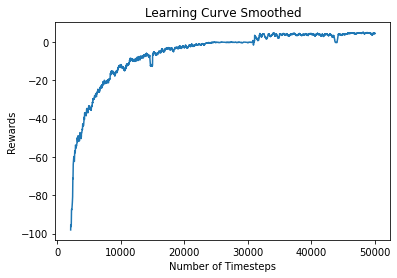

In [ ]:
from stable_baselines import results_plotter
from stable_baselines.results_plotter import load_results, ts2xy

def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')
    
def plot_results(log_folder, title='Learning Curve'):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + " Smoothed")
    plt.show()

plot_results(log_dir)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./dqn_farm/